# Multi-Tissue Constrained Spherical Deconvolution

Multi-Tissue CSD (MT-CSD), or what *Jeurissen et al. (2014)* refers to as Multi-Shell Multi-Tissue CSD (MSMT-CSD), is in extension of regular CSD algorithm. In MT-CSD, Aside from the standard white matter convolution kernel, also a CSF and grey matter kernel are estimated from the data, and fitted simultaneously fitted for better FOD estimation.

$$
\begin{equation}
 E_{\textrm{MT-CSD}}= \underbrace{f_{\textrm{CSF}}\overbrace{E_{\textrm{iso}}(\cdot)}^{\textrm{Isotropic Response}}}_{\textrm{CSF}}+ \underbrace{f_{\textrm{GM}}\overbrace{E_{\textrm{iso}}(\cdot)}^{\textrm{Isotropic Response}}}_{\textrm{Grey Matter}} + \underbrace{f_r\left[\overbrace{\operatorname{FOD}(\operatorname{SH}|l_{\textrm{max}})}^{\textrm{Fiber Distribution}}\,*_{\mathbb{S}^2}\,\overbrace{E_{\textrm{WM}}(\cdot)}^{\textrm{Anisotropic Response}}\right]}_{\textrm{White Matter}}
\end{equation}
$$

The original algorithm uses registered T1 image segmentations of white/grey matter and CSF to obtain these separate kernels, but this has shown to be a difficult and expensive process. Instead, we implement unsupervised approach by *Dhollander et al. (2016)* that directly estimates the three tissue kernels from the dMRI data itself.

Once the kernels are estimated, they can be used exactly as any other Dmipy compartment model. This means they can be used in any modeling framework together with other models as usual.

As you will see, MT-CSD results in very well-defined FOD profiles and hardly any noisy voxels around CSF or Grey matter areas.

## Using Dmipy to set up the MT-CSD Model¶

Setting up the MT-CSD model in Dmipy is very easy. The only thing that needs to be done is to generate the WM/GM/CSF tissue response models from the data using the dhollander16 algorithm. Then, the rest of the modeling can be done as usual.

In [1]:
from dmipy.data import saved_data
scheme_hcp, data_hcp = saved_data.wu_minn_hcp_coronal_slice()

/home/therauser/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


This data slice originates from Subject 100307 of the Human Connectome Project, WU-Minn Consortium (Principal Investigators: David Van Essen and Kamil Ugurbil; 1U54MH091657) funded by the 16 NIH Institutes and Centers that support the NIH Blueprint for Neuroscience Research; and by the McDonnell Center for Systems Neuroscience at Washington University.


In [2]:
scheme_hcp.print_acquisition_info

Acquisition scheme summary

total number of measurements: 288
number of b0 measurements: 18
number of DWI shells: 3

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |18        |0               |0                        |10.6       |43.1      |N/A  
1           |90        |1000            |56                       |10.6       |43.1      |N/A  
2           |90        |2000            |79                       |10.6       |43.1      |N/A  
3           |90        |3000            |97                       |10.6       |43.1      |N/A  


In [3]:
scheme_01_shell, data_01_shell = scheme_hcp.return_pruned_acquisition_scheme([0, 1], data_hcp)
scheme_02_shell, data_02_shell = scheme_hcp.return_pruned_acquisition_scheme([0, 2], data_hcp)
scheme_03_shell, data_03_shell = scheme_hcp.return_pruned_acquisition_scheme([0, 3], data_hcp)
schemes = [scheme_01_shell, scheme_02_shell, scheme_03_shell]
data = [data_01_shell, data_02_shell, data_03_shell]

In [4]:
scheme_01_shell.print_acquisition_info

Acquisition scheme summary

total number of measurements: 108
number of b0 measurements: 18
number of DWI shells: 1

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |18        |0               |0                        |10.6       |43.1      |N/A  
1           |90        |1000            |56                       |10.6       |43.1      |N/A  


In [5]:
from dmipy.tissue_response.three_tissue_response import three_tissue_response_dhollander16
tissue_responses = []
selection_maps = []
for scheme, data in zip(schemes, data):
    wm, gm, csf, selection_map = three_tissue_response_dhollander16(
        scheme, data, wm_algorithm='tournier07',
        wm_N_candidate_voxels=150, gm_perc=0.2, csf_perc=0.4)
    tissue_responses.append([wm, gm, csf])
    selection_maps.append(selection_map)

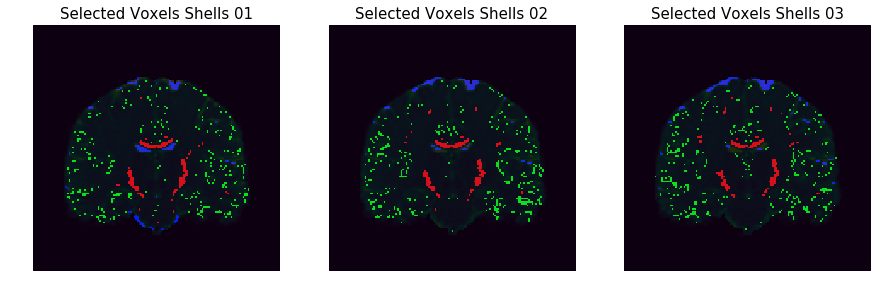

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(figsize=[15, 5], ncols=3)
axs = axs.ravel()

for ax, selection_map, txt in zip(axs, selection_maps, ['Shells 01', 'Shells 02', 'Shells 03']):
    ax.imshow(data_hcp[:, 0, :, 0].T, origin=True)
    ax.imshow(selection_map.squeeze().transpose((1, 0, 2)), origin=True, alpha=0.8)
    ax.set_axis_off()
    ax.set_title('Selected Voxels {}'.format(txt), fontsize=15);

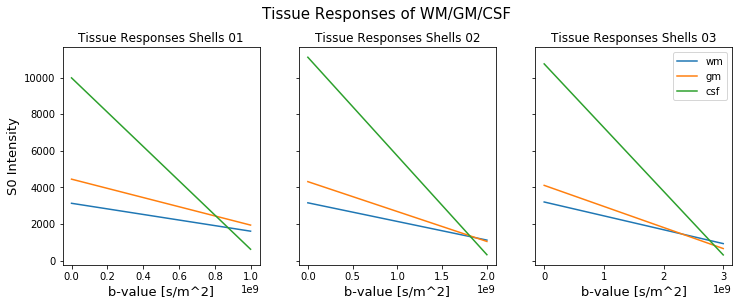

In [7]:
fig, axs = plt.subplots(figsize=[12, 4], ncols=3, sharey=True)
fig.suptitle('Tissue Responses of WM/GM/CSF', fontsize=15, y=1.02)
axs = axs.ravel()
axs[0].set_ylabel('S0 Intensity', fontsize=13)
for ax, scheme, tissue_response, txt in zip(
        axs, schemes, tissue_responses, ['Shells 01', 'Shells 02', 'Shells 03']):
    for response, name in zip(tissue_response, ['wm', 'gm', 'csf']):
        ax.plot(scheme.shell_bvalues, response.tissue_response(), label=name)
    ax.set_xlabel('b-value [s/m^2]', fontsize=13)
    ax.set_title('Tissue Responses {}'.format(txt))
axs[2].legend()

In [ ]:
import time
def single_shell_three_tissue_csd(acquisition_scheme, data, tissue_responses, it_max=4, verbose=False):
    """
    Implementation of Single-Shell (1 shell + b0) three-tissue CSD [1]_.
    
    Parameters
    ----------
    tissue_responses: list of Dmipy tissue response models,
        assumed to be in the same order as they are generated using the dhollander16 tissue
        response estimation, i.e. [wm, gm, csf].
    acquisition_scheme: Dmipy acquisition scheme,
        single shell (or whatever-shell) acquisition scheme.
    data: ND-array of shape (Nx...., NDWI),
        the fitted that is to be fitted.
    
    References
    ----------
    .. [1] DHollander 16 blabla
    """

    fit_args = {
        'acquisition_scheme': acquisition_scheme,
        'data': data,
        'mask': data[..., 0]>0,
        'fit_S0_response': True,
        'verbose': verbose}

    csd_fits = []
    for it in range(it_max):
        start = time.time()
        mt_csd_mod = MultiCompartmentSphericalHarmonicsModel(tissue_responses)
        if it == 0:
            mt_csd_mod.set_fixed_parameter('partial_volume_0', np.zeros(data.shape[:-1]))
        else:
            mt_csd_mod.set_fixed_parameter('partial_volume_0',
                                           mt_csd_fit.fitted_parameters['partial_volume_0'])
        mt_csd_fit = mt_csd_mod.fit(**fit_args)
        csd_fits.append(mt_csd_fit)

        mt_csd_mod = MultiCompartmentSphericalHarmonicsModel(tissue_responses)
        mt_csd_mod.set_fixed_parameter('partial_volume_2',
                                       mt_csd_fit.fitted_parameters['partial_volume_2'])
        mt_csd_fit = mt_csd_mod.fit(**fit_args)
        csd_fits.append(mt_csd_fit)
        computation_time = time.time() - start
        print('finish it {} of {} in {} seconds'.format(it, it_max, int(computation_time)))
    return csd_fits

In [10]:
import numpy as np
def generate_synthetic_multi_tissue_data(acquisition_scheme, tissue_responses, fractions=None):
    if fractions is None:
        fractions = np.random.rand(len(tissue_responses))
        fractions /= fractions.sum()
    data = 0.
    for vf, response in zip(fractions, tissue_responses):
        data += vf * response.S0_response * response(acquisition_scheme, mu=[0., 0.])
    data =  np.array([data])
    return fractions, data

def get_fractions(csd_fits):
    partial_volumes = []
    for fit in csd_fits:
        partial_volumes.append([
            fit.fitted_and_linked_parameters[fit.model.partial_volume_names[0]],
            fit.fitted_and_linked_parameters[fit.model.partial_volume_names[1]],
            fit.fitted_and_linked_parameters[fit.model.partial_volume_names[2]]])
    fractions = np.array(partial_volumes).squeeze().T
    return fractions

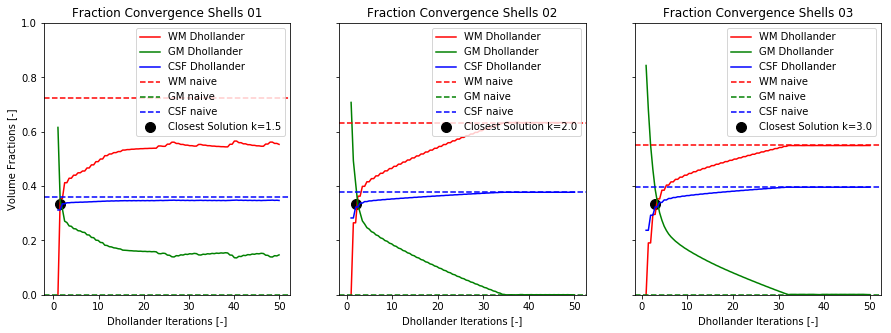

cvxpy found infeasible problem
cvxpy found infeasible problem


In [11]:
gt_fractions = [1/3., 1/3., 1/3.]
it_max = 50
its = np.linspace(1, 50, 100)

fig, axs = plt.subplots(figsize=[15, 5], ncols=3, sharey=True)
axs = axs.ravel()

axs[0].set_ylabel('Volume Fractions [-]')
axs[0].set_ylim(0, 1)
for ax, scheme, tissue_response, txt in zip(axs, schemes, tissue_responses, ['Shells 01', 'Shells 02', 'Shells 03']):
    _, data_test = generate_synthetic_multi_tissue_data(scheme, tissue_response, gt_fractions)
    fits = single_shell_three_tissue_csd(scheme, data_test, tissue_response, it_max=it_max)
    estimated_fractions = get_fractions(fits)
    closest_index = (np.argmin(np.sum((estimated_fractions - 1/3.) ** 2, axis=0)) + 1) / 2.
    
    mt_csd_mod = MultiCompartmentSphericalHarmonicsModel(tissue_response)
    naive_fit = mt_csd_mod.fit(scheme, data_test, fit_S0_response=True, verbose=False)
    
    ax.plot(its, estimated_fractions[0], c='r', label='WM Dhollander')
    ax.plot(its, estimated_fractions[1], c='g', label='GM Dhollander')
    ax.plot(its, estimated_fractions[2], c='b', label='CSF Dhollander')
    ax.axhline(naive_fit.fitted_parameters['partial_volume_0'], c='r', ls='--', label='WM naive')
    ax.axhline(naive_fit.fitted_parameters['partial_volume_1'], c='g', ls='--', label='GM naive')
    ax.axhline(naive_fit.fitted_parameters['partial_volume_2'], c='b', ls='--', label='CSF naive')
    ax.scatter(closest_index, 1/3., s=100, c='k', label='Closest Solution k={}'.format(closest_index))
    ax.set_xlabel('Dhollander Iterations [-]')
    ax.set_title('Fraction Convergence {}'.format(txt))
    ax.legend(loc='upper right')

In [27]:
closest_indices = []
vfs_gt = []
absolute_difference = []
index = 2
for iteration in range(50):
    vf_gt, data_test = generate_synthetic_multi_tissue_data(schemes[index], tissue_responses[index])
    fits = single_shell_three_tissue_csd(schemes[index], data_test, tissue_responses[index], it_max=10)
    estimated_fractions = get_fractions(fits)
    absolute_difference.append(min(np.sum(abs(estimated_fractions.T - vf_gt), axis=1)))
    closest_indices.append((np.argmin(np.sum(abs(estimated_fractions.T - vf_gt), axis=1)) + 1) / 2.)
    vfs_gt.append(vf_gt)

(array([ 0.,  3.,  0.,  2., 44.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.]),
 array([ 1.        ,  1.47368421,  1.94736842,  2.42105263,  2.89473684,
         3.36842105,  3.84210526,  4.31578947,  4.78947368,  5.26315789,
         5.73684211,  6.21052632,  6.68421053,  7.15789474,  7.63157895,
         8.10526316,  8.57894737,  9.05263158,  9.52631579, 10.        ]),
 <a list of 19 Patch objects>)

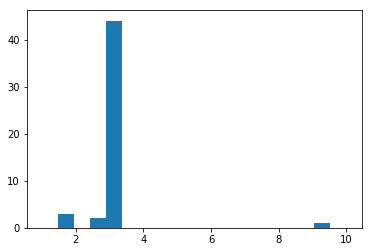

In [29]:
plt.hist(closest_indices, bins=np.linspace(1, 10, 20))

In [30]:
vfs_gt[np.argmax(closest_indices)]

array([0.35830991, 0.00593602, 0.63575407])

In [31]:
absolute_difference[np.argmax(closest_indices)]

0.030762538971773706

In [ ]:
vfs_gt[np.argmin(closest_indices)]

In [ ]:
full_fits = single_shell_three_tissue_csd(scheme_01_shell, data_01_shell, tissue_responses[0])

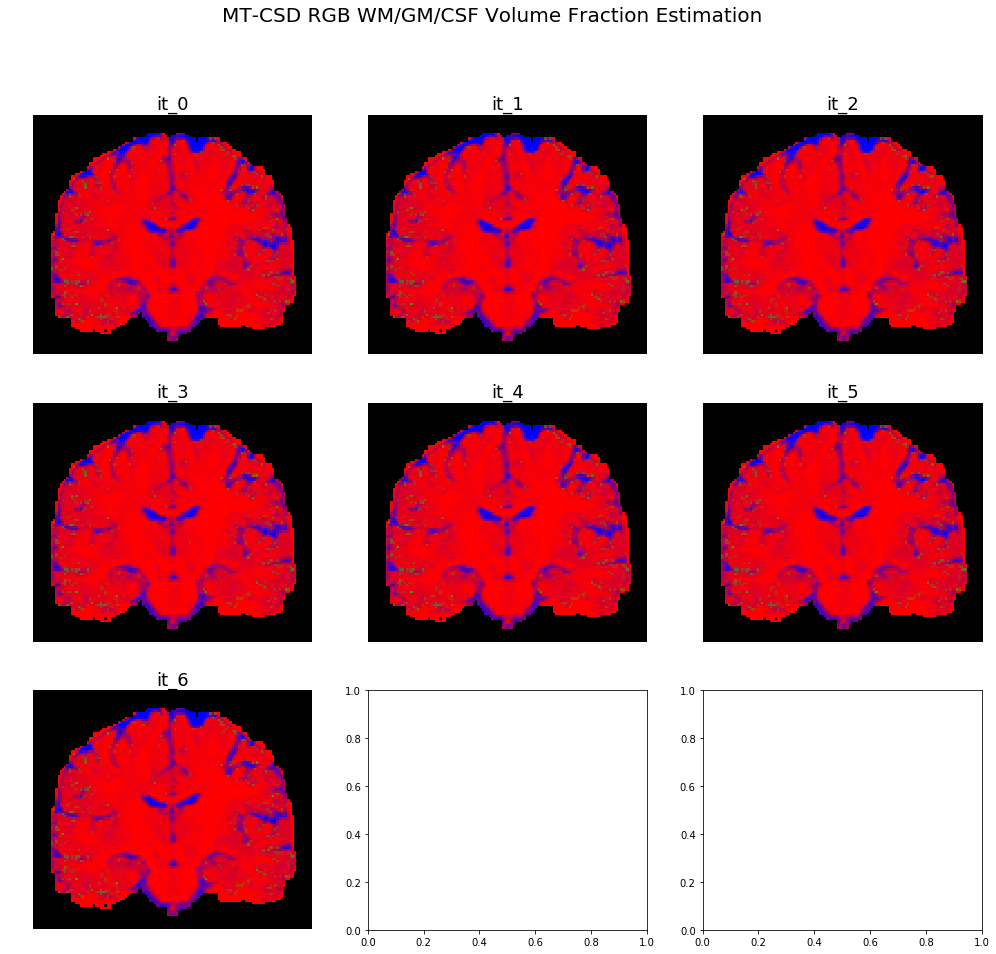

In [21]:
import numpy as np
vfs_all = []

fig, axs = plt.subplots(3, 3, figsize=[17, 15])
axs = axs.ravel()
fig.suptitle('MT-CSD RGB WM/GM/CSF Volume Fraction Estimation', fontsize=20)
for i, fit in enumerate(csd_fits[1:]):
    vfs = []
    names = ['partial_volume_0', 'partial_volume_1', 'partial_volume_2']
    for name in names:
        vfs.append(fit.fitted_and_linked_parameters[name])
    vfs = np.transpose(np.array(vfs), (3, 2, 1, 0))
    vfs_all.append(vfs)
    vfs_sum = np.sum(vfs, axis=-1)
    vfs[vfs_sum > 0] = vfs[vfs_sum > 0] / vfs_sum[vfs_sum > 0][..., None]
    vfs_im = np.squeeze(np.clip(vfs, 0, 1))

    axs[i].imshow(vfs_im[15:-23, 10:-10], origin=True, interpolation='nearest')
    axs[i].axis('off');
    axs[i].set_title("it_{}".format(i), fontsize=18)
    
#     im = axs[i + 2].imshow(np.squeeze(vfs_sum)[15:-23, 10:-10], origin=True, interpolation='nearest')
#     axs[i + 2].axis('off');
#     axs[i + 2].set_title('Estimated volume fraction sum', fontsize=18)
#     fig.colorbar(im, ax=axs[i + 2], shrink=0.8)

### Unsupervised Three-Tissue Response Function Estimation

The dhollander16 algorithm, which heuristically estimates the white/grey matter and CSF response functions from the dMRI data (instead of using a T1 segmentation), can be directly called with the acquisition scheme and the data. The generated tissue response models are always generated in the same order.

To estimate the white matter response function, we can modularly choose any available algorithm, currently:
- the classic 'tournier07' algorithm based on FA only,
- the iterative 'tournier13' algorithm, which refines the response function based on the ratio between the first and secondarly peak of the FODs (currently used in MRtrix).

In the following commands we generate the three response functions, and change some of the default dhollander16 parameters to account for that we're only fitting a single slice instead of a whole brain:

In [2]:
from dmipy.tissue_response.three_tissue_response import three_tissue_response_dhollander16
wm, gm, csf, selection_map = three_tissue_response_dhollander16(
    scheme_hcp, data_hcp, wm_algorithm='tournier13',
    wm_N_candidate_voxels=150, gm_perc=0.2, csf_perc=0.4)
tissue_responses = [wm, gm, csf]

Tournier13 white matter response iteration 1
Setup Tournier07 FOD optimizer in 0.0160799026489 seconds
Fitting of 4530 voxels complete in 13.5685181618 seconds.
Average of 0.00299525787236 seconds per voxel.
0.0 percent candidate voxel overlap.
Tournier13 white matter response iteration 2
Setup Tournier07 FOD optimizer in 0.00790309906006 seconds
Fitting of 4530 voxels complete in 14.2418630123 seconds.
Average of 0.00314389911972 seconds per voxel.
0.0 percent candidate voxel overlap.
Tournier13 white matter response iteration 3
Setup Tournier07 FOD optimizer in 0.00780010223389 seconds
Fitting of 4530 voxels complete in 14.8511221409 seconds.
Average of 0.00327839340858 seconds per voxel.
0.0 percent candidate voxel overlap.
Tournier13 white matter response iteration 4
Setup Tournier07 FOD optimizer in 0.0160119533539 seconds
Fitting of 4530 voxels complete in 15.3660361767 seconds.
Average of 0.00339206096615 seconds per voxel.
100.0 percent candidate voxel overlap.
White matter res

We can visualize which voxels were selected for which tissue responses. Notice that WM (red) was selected from coherent axon bundles, GM (green) from grey matter areas, and CSF (blue) from areas between sulci and ventricles.

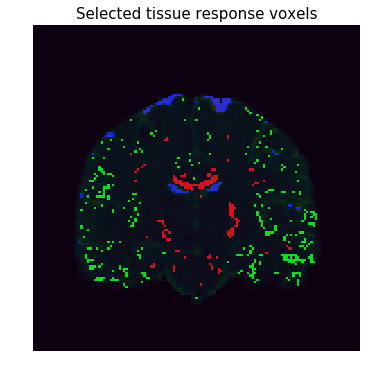

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[6, 6])
plt.imshow(data_hcp[:, 0, :, 0].T, origin=True)
plt.imshow(selection_map.squeeze().transpose((1, 0, 2)), origin=True, alpha=0.8)
plt.axis('off')
plt.title('Selected tissue response voxels', fontsize=15);

We can visualize the tissue signal reponses of the three estimated kernels. Notice that these plots look extremely similar to those shown in *Jeurissen et al. (2014)*.

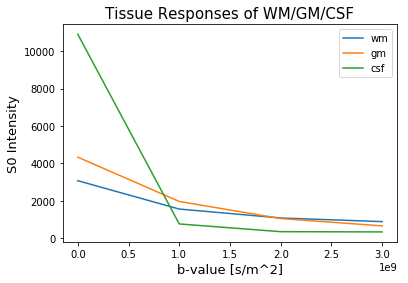

In [4]:
for response, name in zip(tissue_responses, ['wm', 'gm', 'csf']):
    plt.plot(scheme_hcp.shell_bvalues, response.tissue_response(), label=name)
plt.xlabel('b-value [s/m^2]', fontsize=13)
plt.ylabel('S0 Intensity', fontsize=13)
plt.title('Tissue Responses of WM/GM/CSF', fontsize=15)
plt.legend()

Now that the tissue response kernels are known, we can give them to a `MultiCompartmentSphericalHarmonicsModel` and fit them to the data as usual.

Note that tissue reponse models can only produce signals at the b-values (or other acquisition parameters) of the acquisition scheme shells they were estimated from. This means that you cannot use the tissue response kernels of one dataset to fit to another with a different acquisition scheme.

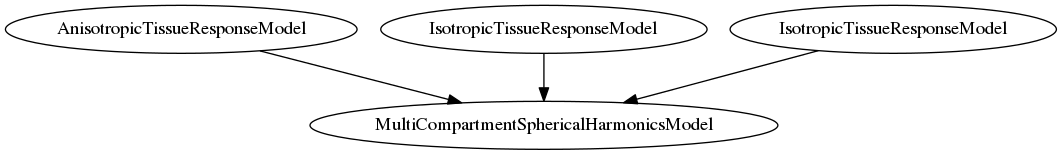

In [5]:
from dmipy.core.modeling_framework import MultiCompartmentSphericalHarmonicsModel
from IPython.display import Image

mt_csd_mod = MultiCompartmentSphericalHarmonicsModel(tissue_responses)
mt_csd_mod.visualize_model_setup(view=False, cleanup=False)
Image('Model Setup.png')

## Fitting MT-CSD to the Signal Attenuation or the Raw Signal

Tissue response models differ from parametric models in that they have a data-dependent, non-unity S0 tissue response. Including the S0-response in the fitting of MT-CSD affects both the estimation of the volume fractions and the shape of the FOD, as we will show below.

We can choose to include the S0 response in the fitting by setting `fit_S0_response=True`. This means the models are being fitted directly to the diffusion signal, instead of normalized models being fitted to the normalized signal attenuation.

In [6]:
fit_args = {'acquisition_scheme': scheme_hcp, 'data': data_hcp, 'mask': data_hcp[..., 0]>0}

mt_csd_fits = []
for fit_S0_response in [True, False]:
    mt_csd_fits.append(mt_csd_mod.fit(fit_S0_response=fit_S0_response, **fit_args))

Setup CVXPY FOD optimizer in 0.00631618499756 seconds
Using parallel processing with 8 workers.
Fitting of 8181 voxels complete in 133.908782005 seconds.
Average of 0.0163682657383 seconds per voxel.
Setup CVXPY FOD optimizer in 0.00947713851929 seconds
Using parallel processing with 8 workers.
Fitting of 8181 voxels complete in 166.428038836 seconds.
Average of 0.0203432390705 seconds per voxel.


Now that the fractions are fitted and there are 3, we can also visualize them as an RGB image. Notice that the WM/GM/CSF areas are reasonably nicely segmented by the estimation itself.

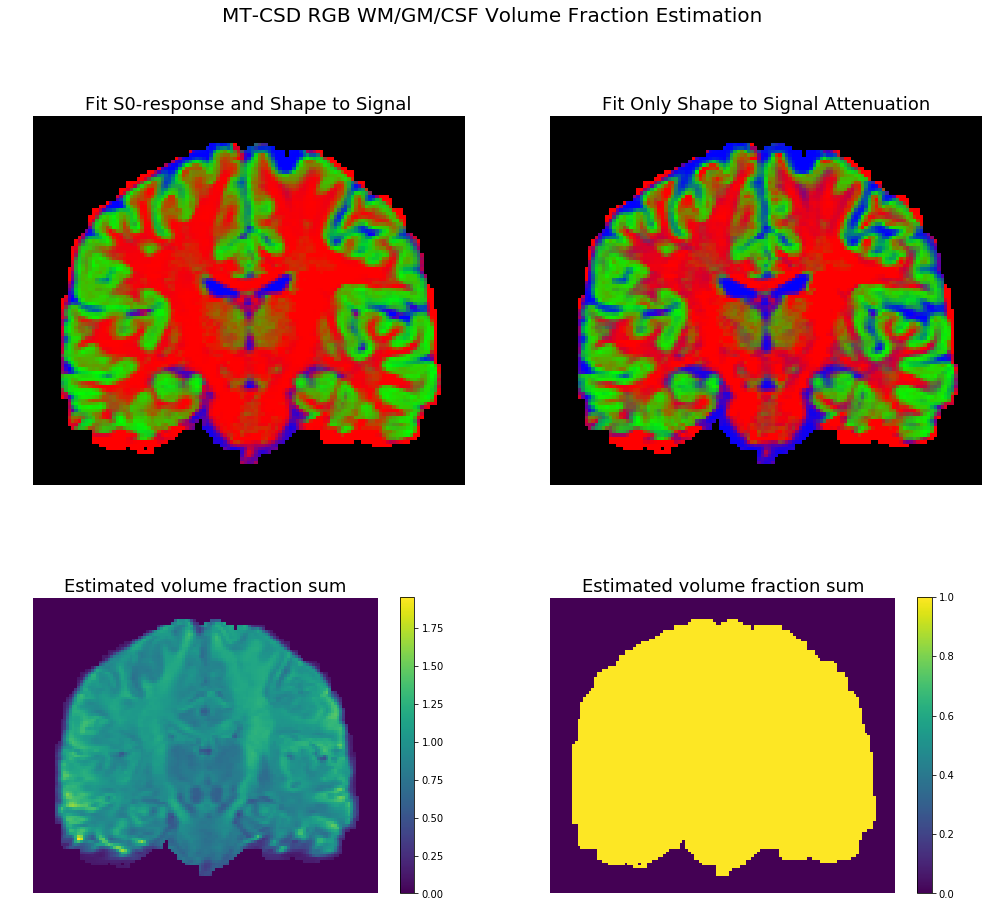

In [36]:
import numpy as np
txts = ['Fit S0-response and Shape to Signal', 'Fit Only Shape to Signal Attenuation']
vfs_all = []

fig, axs = plt.subplots(2, 2, figsize=[17, 15])
axs = axs.ravel()
fig.suptitle('MT-CSD RGB WM/GM/CSF Volume Fraction Estimation', fontsize=20)
for i, fit in enumerate(mt_csd_fits):
    vfs = []
    names = ['partial_volume_0', 'partial_volume_1', 'partial_volume_2']
    for name in names:
        vfs.append(fit.fitted_parameters[name])
    vfs = np.transpose(np.array(vfs), (3, 2, 1, 0))
    vfs_all.append(vfs)
    vfs_sum = np.sum(vfs, axis=-1)
    vfs[vfs_sum > 0] = vfs[vfs_sum > 0] / vfs_sum[vfs_sum > 0][..., None]
    vfs_im = np.squeeze(np.clip(vfs, 0, 1))

    axs[i].imshow(vfs_im[15:-23, 10:-10], origin=True, interpolation='nearest')
    axs[i].axis('off');
    axs[i].set_title(txts[i], fontsize=18)
    
    im = axs[i + 2].imshow(np.squeeze(vfs_sum)[15:-23, 10:-10], origin=True, interpolation='nearest')
    axs[i + 2].axis('off');
    axs[i + 2].set_title('Estimated volume fraction sum', fontsize=18)
    fig.colorbar(im, ax=axs[i + 2], shrink=0.8)

Notice that the estimated volume fractions differ when including S0 response (left) compared to fitting the normalized signal attenuation.
- CSF is much more tightly delineated, which makes sense because CSF has a much higher S0-reponse than WM/GM.
- When fitting the S0-response we do not impose any unity constraint on the volume fractions. This is important we otherwise the fitting will be biased when the S0 response of the tissue differs from the response, but overall you can see the fractions don't vary much from unity.

### Visualizing Fiber Orientation Distributions

As before, we can visualize the FOD estimated using MT-CSD. We do both with and without including the S0 response.

/user/rfick/home/anaconda2/lib/python2.7/site-packages/vtk/util/numpy_support.py:134: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


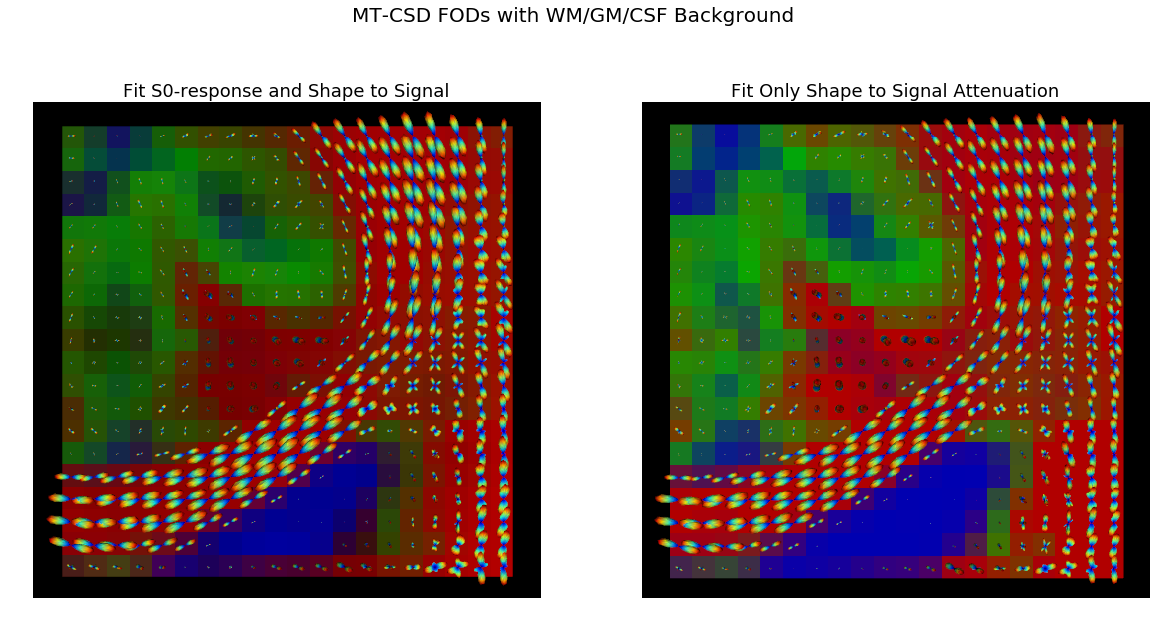

In [9]:
from dipy.data import get_sphere
from dipy.viz.actor import slicer
from dipy.viz import fvtk
import numpy as np
import matplotlib.image as mpimg

sphere = get_sphere(name='symmetric724')
affine = np.eye(4)
affine[0,3] = -10
affine[1,3] = -10

txts = ['Fit S0-response and Shape to Signal', 'Fit Only Shape to Signal Attenuation']

fig, axs = plt.subplots(1, 2, figsize=[20, 10])
axs = axs.ravel()
fig.suptitle('MT-CSD FODs with WM/GM/CSF Background', fontsize=20)

for i, (txt, vfs, fit) in enumerate(zip(txts, vfs_all, mt_csd_fits)):
    fods = fit.fod(sphere.vertices)

    vfs2 = np.transpose(vfs, (2, 1, 0, 3))
    ai_im = slicer(vfs2[70:90,0, 70:90, None, :],
        interpolation='nearest', affine=affine, opacity=0.7)

    ren = fvtk.ren()
    fod_spheres = fvtk.sphere_funcs(fods[70:90,:, 70:90], sphere, scale=1., norm=False)
    fod_spheres.RotateX(90)
    fod_spheres.RotateZ(180)
    fod_spheres.RotateY(180)
    fvtk.add(ren, fod_spheres)
    fvtk.add(ren, ai_im)
    fvtk.record(ren=ren, size=[700, 700])

    img = mpimg.imread('dipy.png')

    axs[i].imshow(img[100:-97, 100:-85])
    axs[i].set_title(txt, fontsize=18)
    axs[i].axis('off');

We show the RGB volume fractions as the background of the FODs. Red is WM, green is GM and blue is CSF. Notice that in WM the FODs are very sharp and noisefree, and the FODs have shrunken to be basically invisible in areas with higher (estimated) GM/CSF constributions. In other words, the signal contributions that would mess up the FOD in regular CSD have now instead been captured by the isotropic representations, resulting in cleaner FODs.

That being said, there are some observations to be made w.r.t. including the S0 response or not.
- The CSF area is smaller when including the S0 response, i.e. the overestimation of the CSF fraction has been reduced by including the tissue responses,
- The FOD profiles in the crossing area near the centrum semiovale (right side) are a bit more blobby when including the S0 response for some reason.

It is likely that these results will improve further when estimating the response functions from an entire brain (instead of just this example slice). 

## References
- Tournier, J-Donald, Fernando Calamante, and Alan Connelly. "Robust determination of the fibre orientation distribution in diffusion MRI: non-negativity constrained super-resolved spherical deconvolution." Neuroimage 35.4 (2007): 1459-1472.
- Dhollander, T.; Raffelt, D. & Connelly, A. Unsupervised 3-tissue response function estimation from single-shell or multi-shell diffusion MR data without a co-registered T1 image. ISMRM Workshop on Breaking the Barriers of Diffusion MRI, 2016, 5
- Jeurissen, Ben, et al. "Multi-tissue constrained spherical deconvolution for improved analysis of multi-shell diffusion MRI data." NeuroImage 103 (2014): 411-426.